# Naturale Language Processing notebook example

Welcome to NLP notebook example!

The first time you run this notebook execute the following line (you can comment it next time): be sure to have requirements.txt

In [1]:
import sys
!{sys.executable} -m pip install --user -r requirements.txt
#install --user -r requirements.txt

Processing /home/jovyan/.cache/pip/wheels/33/de/03/7346ae70da7f980f78569668caf78fb2d678b176e549557c7d/gensim-3.8.1-cp38-cp38-linux_x86_64.whl
  Using cached pyonmttok-1.16.1-cp38-cp38-manylinux1_x86_64.whl (2.2 MB)
  Using cached scikit_learn-0.22.1-cp38-cp38-manylinux1_x86_64.whl (7.0 MB)
  Using cached matplotlib-3.1.2-cp38-cp38-manylinux1_x86_64.whl (13.1 MB)


In [2]:
#!python -m pip install -U joblib
#!pip install smart_open==2.0.0
#!pip3 install -U joblib
#!conda install joblib

In [5]:
import pandas as pd 
import numpy as np
from gensim.models import Word2Vec
from time import time
import csv
import preprocessing as pp
import nlp_utility

In [6]:
df=pd.read_csv('message_example.csv')

In [7]:
df.head()

,error_category,error_message
0,PERMISSION_DENIED,[gfalt_copy_file][perform_copy][gfal_http_copy...
1,PERMISSION_DENIED,[gfalt_copy_file][perform_copy][gfal_http_copy...
2,COMMUNICATION_ERROR_ON_SEND,DESTINATION OVERWRITE srm-ifce err: Communicat...
3,INVALID_REQUEST_DESCRIPTOR,DESTINATION MAKE_PARENT srm-ifce err: Invalid ...
4,CONNECTION_TIMED_OUT,DESTINATION SRM_PUT_TURL srm-ifce err: Connect...


In [8]:
pd.set_option('display.max_colwidth', -1)
df.head()

<ipython-input-8-8924a054d440>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,error_category,error_message
0,PERMISSION_DENIED,[gfalt_copy_file][perform_copy][gfal_http_copy] DESTINATION OVERWRITE [gfal_http_copy_overwrite] [gfal_http_exists][gfal_http_access][davix2gliberr] Failure (Neon): SSL handshake failed: Connection timed out during SSL handshake after 1 attempts
1,PERMISSION_DENIED,[gfalt_copy_file][perform_copy][gfal_http_copy] DESTINATION OVERWRITE [gfal_http_copy_overwrite] [gfal_http_exists][gfal_http_access][davix2gliberr] Failure (Neon): SSL handshake failed: Connection timed out during SSL handshake after 1 attempts
2,COMMUNICATION_ERROR_ON_SEND,"DESTINATION OVERWRITE srm-ifce err: Communication error on send, err: [SE][srmRm][] httpg://storm-fe.cr.cnaf.infn.it:8444/srm/managerv2: CGSI-gSOAP running on fts-atlas-006.cern.ch reports Error reading token data header: Connection closed"
3,INVALID_REQUEST_DESCRIPTOR,"DESTINATION MAKE_PARENT srm-ifce err: Invalid request descriptor, err: [SE][Mkdir][SRM_INVALID_REQUEST] httpg://storm.ifca.es:8444/srm/managerv2: srm://storm.ifca.es/srm:/srm01.ifca.es:8444/srm/managerv2?SFN=/cms/store/user/cprieels/CRAB_PrivateMC/DMscalar_Dilepton_top_tWChan_Mchi1_Mphi450_RunIIAutumn18_AODSIM_PrivateFullProd_Sep2020_v2/201106_085455/0000/log: invalid surl: srm://storm.ifca.es"
4,CONNECTION_TIMED_OUT,"DESTINATION SRM_PUT_TURL srm-ifce err: Connection timed out, err: [SE][StatusOfPutRequest][ETIMEDOUT] httpg://storm-fe.cr.cnaf.infn.it:8444/srm/managerv2: User timeout over"


## Preprocessing
Messages are cleaned from file paths, urls etc.(this process can be time requiring)

Tokenization is done inline and tokens cleaned from a stopword list are given as input to Word2Vec model.

In [9]:
before_number=df.shape[0] #message number before cleaning
print('...cleaning')
start_time_preproc= time()
df['cleaned_strings'] = pp.clean_messages(df['error_message'])
prepr_time=time() - start_time_preproc


...cleaning


In [10]:
df_cleaned=df.copy()

In [11]:
df_cleaned.drop_duplicates(['cleaned_strings'],inplace=True)
after_number=df_cleaned.shape[0] #message number after cleaning

In [12]:
print("number of  messages before cleaning:",before_number)
print("number of  messages after cleaning:",after_number)

number of  messages before cleaning: 711828
number of  messages after cleaning: 641


In [13]:
df_cleaned

,error_category,error_message,cleaned_strings
0,PERMISSION_DENIED,[gfalt_copy_file][perform_copy][gfal_http_copy] DESTINATION OVERWRITE [gfal_http_copy_overwrite] [gfal_http_exists][gfal_http_access][davix2gliberr] Failure (Neon): SSL handshake failed: Connection timed out during SSL handshake after 1 attempts,destination overwrite failure neon ssl handshake failed connection timed out during ssl handshake after attempts
2,COMMUNICATION_ERROR_ON_SEND,"DESTINATION OVERWRITE srm-ifce err: Communication error on send, err: [SE][srmRm][] httpg://storm-fe.cr.cnaf.infn.it:8444/srm/managerv2: CGSI-gSOAP running on fts-atlas-006.cern.ch reports Error reading token data header: Connection closed",destination overwrite srm ifce err communication error on send err cgsi gsoap running on reports error reading token data header connection closed
3,INVALID_REQUEST_DESCRIPTOR,"DESTINATION MAKE_PARENT srm-ifce err: Invalid request descriptor, err: [SE][Mkdir][SRM_INVALID_REQUEST] httpg://storm.ifca.es:8444/srm/managerv2: srm://storm.ifca.es/srm:/srm01.ifca.es:8444/srm/managerv2?SFN=/cms/store/user/cprieels/CRAB_PrivateMC/DMscalar_Dilepton_top_tWChan_Mchi1_Mphi450_RunIIAutumn18_AODSIM_PrivateFullProd_Sep2020_v2/201106_085455/0000/log: invalid surl: srm://storm.ifca.es",destination srm ifce err invalid request descriptor err invalid surl
4,CONNECTION_TIMED_OUT,"DESTINATION SRM_PUT_TURL srm-ifce err: Connection timed out, err: [SE][StatusOfPutRequest][ETIMEDOUT] httpg://storm-fe.cr.cnaf.infn.it:8444/srm/managerv2: User timeout over",destination srm ifce err connection timed out err user timeout over
8,INPUT/OUTPUT_ERROR,"TRANSFER ERROR: Copy failed with mode 3rd pull, with error: Transfer failed: failure: Remote copy failed with status code 0: error:14077410:SSL routines:SSL23_GET_SERVER_HELLO:sslv3 alert handshake failure",transfer error copy failed with mode pull with error transfer failed failure remote copy failed with status code alert handshake failure
...,...,...,...
697118,INPUT/OUTPUT_ERROR,"TRANSFER ERROR: Copy failed with mode 3rd push, with error: Transfer failed: failure: Failed to select pool: CacheException(rc=10006;msg=Source pool failed (no response))",transfer error copy failed with mode push with error transfer failed failure failed to select pool pool failed no response
698751,INPUT/OUTPUT_ERROR,"TRANSFER ERROR: Copy failed with mode 3rd pull, with error: Transfer failed: failure: java.security.cert.CertificateException: The peers certificate with subjects DN CN=dpmpool23.farm.particle.cz,O=Fyzikalni ustav AV CR\, v. v. i.,L=Prague,C=CZ,DC=tcs,DC=terena,DC=org was rejected. The peers certificate status is: FAILED The following validation errors were found:;error at position 0 in chain, problematic certificate subject: CN=dpmpool23.farm.particle.cz,O=Fyzikalni ustav AV CR\, v. v. i.,L=Prague,C=CZ,DC=tcs,DC=terena,DC=org (category: CRL): Signature of a CRL",transfer error copy failed with mode pull with error transfer failed failure the peers certificate with subjects dn ustav av cr v v was rejected the peers certificate status is failed the following validation errors were found error at position in chain problematic certificate subject ustav av cr v v category crl signature of a crl
699396,PERMISSION_DENIED,DESTINATION SRM_PUT_TURL error on the turl request : [SE][StatusOfPutRequest][SRM_AUTHORIZATION_FAILURE] Create/Write access to srm://se03.esc.qmul.ac.uk/atlas/atlasscratchdisk/rucio/mc16_13TeV/bd/a1/DAOD_JETM12.22819163._000038.pool.root.1 denied!,destination error on the turl request create access to denied
703603,INPUT/OUTPUT_ERROR,"[gfalt_copy_file][perform_copy] TRANSFER [gfal_http_copy] ERROR: Copy failed with mode 3rd pull, with error: [davix2gliberr] Transfer failed: failure: java.security.cert.CertificateException: The peers certificate with subjects DN CN=golias100.farm.particle.cz,O=Institute of Physics of the Academy of Sciences of the CR,DC=cesnet-ca,DC=cz was rejected. The peers certificate status is: FAILED T

In [14]:
c=nlp_utility.callback()

In [15]:
corpus = pp.MyCorpus(df_cleaned)
print('...starting training')
start_time_train = time()
model = Word2Vec(sentences=corpus,compute_loss=True,size=300,window=7, min_count=1, workers=4, iter=30,callbacks=[c])
tot_time=time() - start_time_train
model.save('example_model.model')

...starting training
Loss after epoch 0: 22310.333984375
Loss after epoch 1: 20605.248046875
Loss after epoch 2: 16797.1484375
Loss after epoch 3: 15656.77734375
Loss after epoch 4: 15243.59375
Loss after epoch 5: 15002.828125
Loss after epoch 6: 14142.0625
Loss after epoch 7: 13349.1484375
Loss after epoch 8: 12923.265625
Loss after epoch 9: 12351.421875
Loss after epoch 10: 12112.8125
Loss after epoch 11: 11753.8125
Loss after epoch 12: 11509.84375
Loss after epoch 13: 11386.375
Loss after epoch 14: 11055.765625
Loss after epoch 15: 10939.203125
Loss after epoch 16: 10682.625
Loss after epoch 17: 10545.125
Loss after epoch 18: 10449.3125
Loss after epoch 19: 10379.671875
Loss after epoch 20: 10449.59375
Loss after epoch 21: 10124.125
Loss after epoch 22: 9990.59375
Loss after epoch 23: 10011.4375
Loss after epoch 24: 9849.96875
Loss after epoch 25: 9701.28125
Loss after epoch 26: 9954.3125
Loss after epoch 27: 9611.6875
Loss after epoch 28: 9723.46875
Loss after epoch 29: 9607.75


Text(0, 0.5, 'delta loss')

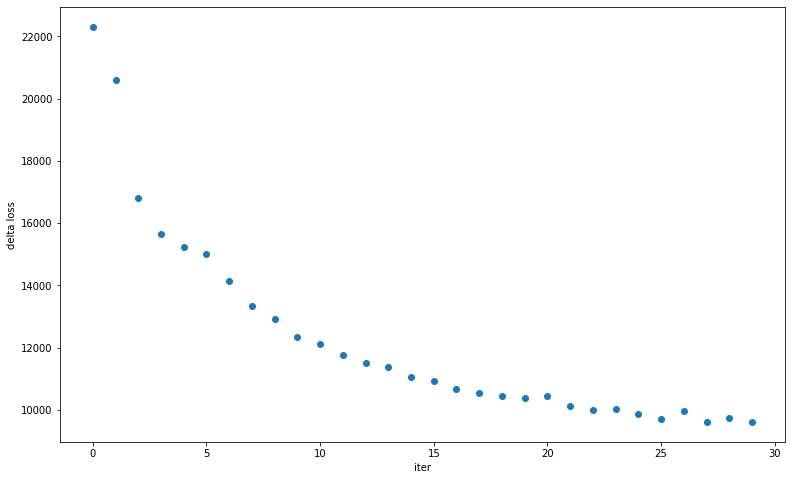

In [16]:
from matplotlib import pyplot as plt
fig, ax=plt.subplots(figsize=(13,8))
ax.scatter(np.arange(0,len(c.loss_vec)),c.loss_vec)
ax.set_xlabel('iter')
ax.set_ylabel('delta loss')


In [17]:
print('preprocessing time: %.2f seconds'% prepr_time)
print('training time: %.2f seconds'%tot_time)

preprocessing time: 151.09 seconds
training time: 3.83 seconds


### Just few words about MyCorpus object

Why didn't we feed word2vec model with a plain Python list of tokens? MyCorpus object is much more memory friendly! A list would reside fully in the memory;with MyCorpus object, instead, **at most one vector** resides in RAM **at a time**. In such a way the corpus can be as large as we want.

In [18]:
print(corpus)

*print* just outputs address of the object in memory. To see the constituent vectors, let’s iterate over the corpus and print each document vector (one at a time):

In [19]:
for line in corpus:
    print(line)

['destination', 'overwrite', 'failure', 'neon', 'ssl', 'handshake', 'failed', 'connection', 'timed', 'out', 'during', 'ssl', 'handshake', 'after', 'attempts']
['destination', 'overwrite', 'communication', 'error', 'send', 'cgsi', 'gsoap', 'running', 'reports', 'error', 'reading', 'token', 'data', 'header', 'connection', 'closed']
['destination', 'invalid', 'request', 'descriptor', 'invalid', 'surl']
['destination', 'connection', 'timed', 'out', 'user', 'timeout', 'over']
['transfer', 'error', 'copy', 'failed', 'mode', 'pull', 'error', 'transfer', 'failed', 'failure', 'remote', 'copy', 'failed', 'status', 'code', 'alert', 'handshake', 'failure']
['transfer', 'error', 'copy', 'failed', 'mode', 'push', 'error', 'request', 'cancellation', 'requested']
['transfer', 'error', 'copy', 'failed', 'mode', 'pull', 'error', 'error', 'string', 'contains', 'not', 'valid', 'utf', 'chars']
['source', 'error', 'turl', 'request', 'file', 'not', 'online']
['transfer', 'error', 'copy', 'failed', 'mode', 'p

## Understanding Word2Vec
Let's play a bit with our model to understand what it is doing.

Getting model vocabulary and total amount of words:

In [20]:
len(model.wv.vocab)

647

In [21]:
model.wv.vocab

{'destination': <gensim.models.keyedvectors.Vocab at 0x7f8917fcea00>,
 'overwrite': <gensim.models.keyedvectors.Vocab at 0x7f8917fcea30>,
 'failure': <gensim.models.keyedvectors.Vocab at 0x7f8917fcea90>,
 'neon': <gensim.models.keyedvectors.Vocab at 0x7f8917fceaf0>,
 'ssl': <gensim.models.keyedvectors.Vocab at 0x7f8917fceb50>,
 'handshake': <gensim.models.keyedvectors.Vocab at 0x7f8917fcebb0>,
 'failed': <gensim.models.keyedvectors.Vocab at 0x7f8917fcec10>,
 'connection': <gensim.models.keyedvectors.Vocab at 0x7f8917fcec70>,
 'timed': <gensim.models.keyedvectors.Vocab at 0x7f8917fcecd0>,
 'out': <gensim.models.keyedvectors.Vocab at 0x7f8917fced30>,
 'during': <gensim.models.keyedvectors.Vocab at 0x7f8917fced90>,
 'after': <gensim.models.keyedvectors.Vocab at 0x7f8917fcedf0>,
 'attempts': <gensim.models.keyedvectors.Vocab at 0x7f8917fcee50>,
 'communication': <gensim.models.keyedvectors.Vocab at 0x7f8917fceeb0>,
 'error': <gensim.models.keyedvectors.Vocab at 0x7f8917fcef10>,
 'send': <g

Checking the "most similar words", using the default "cosine similarity" measure:

In [22]:
print(model.wv.most_similar(positive=['pull','push'])) #sum

[('mode', 0.9985013008117676), ('failure', 0.9896916151046753), ('copy', 0.9877747893333435), ('failed', 0.9817980527877808), ('transfer', 0.9691269993782043), ('remote', 0.957771360874176), ('code', 0.9468125104904175), ('select', 0.9373974800109863), ('sslhandshakeexception', 0.9370776414871216), ('problem', 0.9357748031616211)]


In [23]:
print(model.wv.most_similar(positive=['pull'],negative=['push']))#difference

[('geonmo', 0.6358527541160583), ('national', 0.5699359178543091), ('communicat', 0.5599034428596497), ('signed', 0.5406615734100342), ('whole', 0.5014688372612), ('affecting', 0.4829644560813904), ('found', 0.47476649284362793), ('fr', 0.47135233879089355), ('certificate', 0.4606175422668457), ('validation', 0.45598262548446655)]


Getting similarity score for each pair and checking not matching word:

In [24]:
pairs = [
    ('pull', 'push'),  #similar role
    ('pull', 'copy'),   #often close
    ('pull', 'time'),  #sometimes appearing together
    ('pull', 'directory'),    # sometimes appearing together
    ('pull', 'not'),
]
for w1, w2 in pairs:
    print('%r\t%r\t%.2f' % (w1, w2, model.wv.similarity(w1, w2)))


'pull'	'push'	0.98
'pull'	'copy'	0.98
'pull'	'time'	0.33
'pull'	'directory'	-0.27
'pull'	'not'	-0.05


In [25]:
print(model.wv.doesnt_match(['pull','push','mode','not']))

not


/home/jovyan/.local/lib/python3.8/site-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


In [26]:
df_cleaned['error_message'][df_cleaned['error_message'].astype(str).str.contains('pull',na=False)]

8         TRANSFER  ERROR: Copy failed with mode 3rd pull, with error: Transfer failed: failure: Remote copy failed with status code 0: error:14077410:SSL routines:SSL23_GET_SERVER_HELLO:sslv3 alert handshake failure                                                                                                                                                                                                                                                                                                                                                                                                                                               
15        TRANSFER  ERROR: Copy failed with mode 3rd pull, with error: Error string contains not valid UTF-8 chars                                                                                                                                                                                                                                              

In [27]:
df_cleaned[(df_cleaned['error_message'].astype(str).str.contains('pull',na=False)) & (df_cleaned['error_message'].astype(str).str.contains('directory',na=False) )]

,error_category,error_message,cleaned_strings
75,INPUT/OUTPUT_ERROR,"TRANSFER ERROR: Copy failed with mode 3rd pull, with error: Transfer failed: failure: Too many attempts to select pool; last pool lunarc_lu_se_103-hep@dc103-hep_lunarc_lu_seDomain failed with Could not create MoverProtocol mover for RemoteHttpsDataTransfer-1.1:https://torik1.ulakbim.gov.tr:443/dpm/ulakbim.gov.tr/home/atlas/atlasscratchdisk/rucio/tests/65/39/file77_784e172d-25f0-41bc-a36a-57c04493132e?copy_mode=pull: directory not found: /etc/grid-security/certificates",transfer error copy failed with mode pull with error transfer failed failure too many attempts to select pool last pool failed with could not create moverprotocol mover for remotehttpsdatatransfer directory not found
84,INPUT/OUTPUT_ERROR,"TRANSFER ERROR: Copy failed with mode 3rd pull, with error: Transfer failed: failure: Too many attempts to select pool; last pool s11-iep-grid.saske.sk_2@s11-iep-gridDomain failed with Could not create MoverProtocol mover for RemoteHttpsDataTransfer-1.1:https://atlas.dcache.nikhef.nl:2880/pnfs/nikhef.nl/data/atlas/atlasscratchdisk/rucio/tests/df/4c/file75_c5454de7-0bd7-4222-9f57-a78a24d73fc6?copy_mode=pull: directory not found: /etc/grid-security/certificates",transfer error copy failed with mode pull with error transfer failed failure too many attempts to select pool last pool griddomain failed with could not create moverprotocol mover for remotehttpsdatatransfer directory not found
28989,INPUT/OUTPUT_ERROR,"TRANSFER ERROR: Copy failed with mode 3rd pull, with error: Transfer failed: failure: Post-processing failed: No such file or directory: 0000A76CAA7FAD624B7A8D0DB7369EAABB3C",transfer error copy failed with mode pull with error transfer failed failure post processing failed no such file or directory


Even if 'pull' and 'push' never appear together the model understands they have similar role (high similarity score): 

In [28]:
df_cleaned[(df_cleaned['error_message'].astype(str).str.contains('pull',na=False)) & (df_cleaned['error_message'].astype(str).str.contains('push',na=False) )]

,error_category,error_message,cleaned_strings


Dictionary of known words and their frequency in the corpus:

In [29]:
w2c = dict()
for item in model.wv.vocab:
    w2c[item] = model.wv.vocab[item].count
w2cSorted=dict(sorted(w2c.items(), key=lambda x: x[1],reverse=True))
w2cSortedList = list(w2cSorted.keys())
w2cSorted

{'error': 1113,
 'failed': 752,
 'transfer': 591,
 'copy': 319,
 'certificate': 298,
 'mode': 253,
 'server': 241,
 'failure': 211,
 'responded': 197,
 'found': 165,
 'not': 161,
 'pull': 154,
 'peers': 152,
 'chain': 139,
 'status': 133,
 'destination': 116,
 'no': 113,
 'connection': 109,
 'file': 95,
 'at': 89,
 'rejected': 87,
 'system': 86,
 'checksum': 85,
 'push': 81,
 'out': 79,
 'timed': 78,
 'subjects': 76,
 'dn': 76,
 'following': 76,
 'validation': 76,
 'errors': 76,
 'position': 74,
 'category': 72,
 'end': 70,
 'problematic': 69,
 'subject': 69,
 'could': 64,
 'crl': 64,
 'request': 62,
 'data': 61,
 'connect': 55,
 'problem': 54,
 'source': 48,
 'xrdcl': 47,
 'copyprocess': 47,
 'run': 47,
 'unable': 46,
 'ca': 46,
 'reason': 44,
 'remote': 43,
 'errno': 43,
 'command': 42,
 'attempts': 39,
 'code': 39,
 'globuserror': 39,
 'while': 36,
 'http': 35,
 'neon': 34,
 'ssl': 34,
 'sending': 34,
 'handshake': 33,
 'get': 33,
 'after': 32,
 'open': 32,
 'or': 31,
 'directory': 

## Getting more into NLP tasks

### Example of Supervised Learning
Let's test model ability to associate the right error category.

In [30]:
model_name='example_model.model'
model=Word2Vec.load(model_name)

In [31]:
vectors_sent=nlp_utility.vectorize_messages(df_cleaned['cleaned_strings'],model,tf_idf=True)

In [32]:
len(vectors_sent)


641

In [33]:
from sklearn.model_selection import train_test_split
x_train, x_test,y_train, y_test = train_test_split(vectors_sent,df_cleaned['error_category'].values,test_size=0.2, random_state = 42)
mex_train, mex_test,cat_train, cat_test = train_test_split(df_cleaned['error_message'].values,df_cleaned['error_category'].values,test_size=0.2, random_state = 42)

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

logreg = LogisticRegression(n_jobs=1, C=1e5,class_weight='balanced',multi_class='auto',solver='lbfgs',max_iter=170)
#print(y_train)
logreg = logreg.fit(x_train, y_train)
#y_pred = logreg.predict(x_test)
#print('accuracy %s' % accuracy_score(y_test, y_pred))
#print(classification_report(y_test, y_pred))

AttributeError: 'str' object has no attribute 'decode'

Possible warnings if some labels in y_test don't appear in y_pred (i.e some labels are never predicted)

In [36]:
set(y_test) - set(y_pred) #if empty you shouldn't have warnings

NameError: name 'y_pred' is not defined

In [ ]:
d={'y_test':y_test,'y_pred':y_pred,'mex':mex_test}
df_comparison=pd.DataFrame(data=d)
df_comparison

### 2-D Visualization of vector space: words and error messages (cleaned)

In [44]:
#allows interactive cursors

In [45]:
%matplotlib nbagg 

<IPython.core.display.Javascript object>


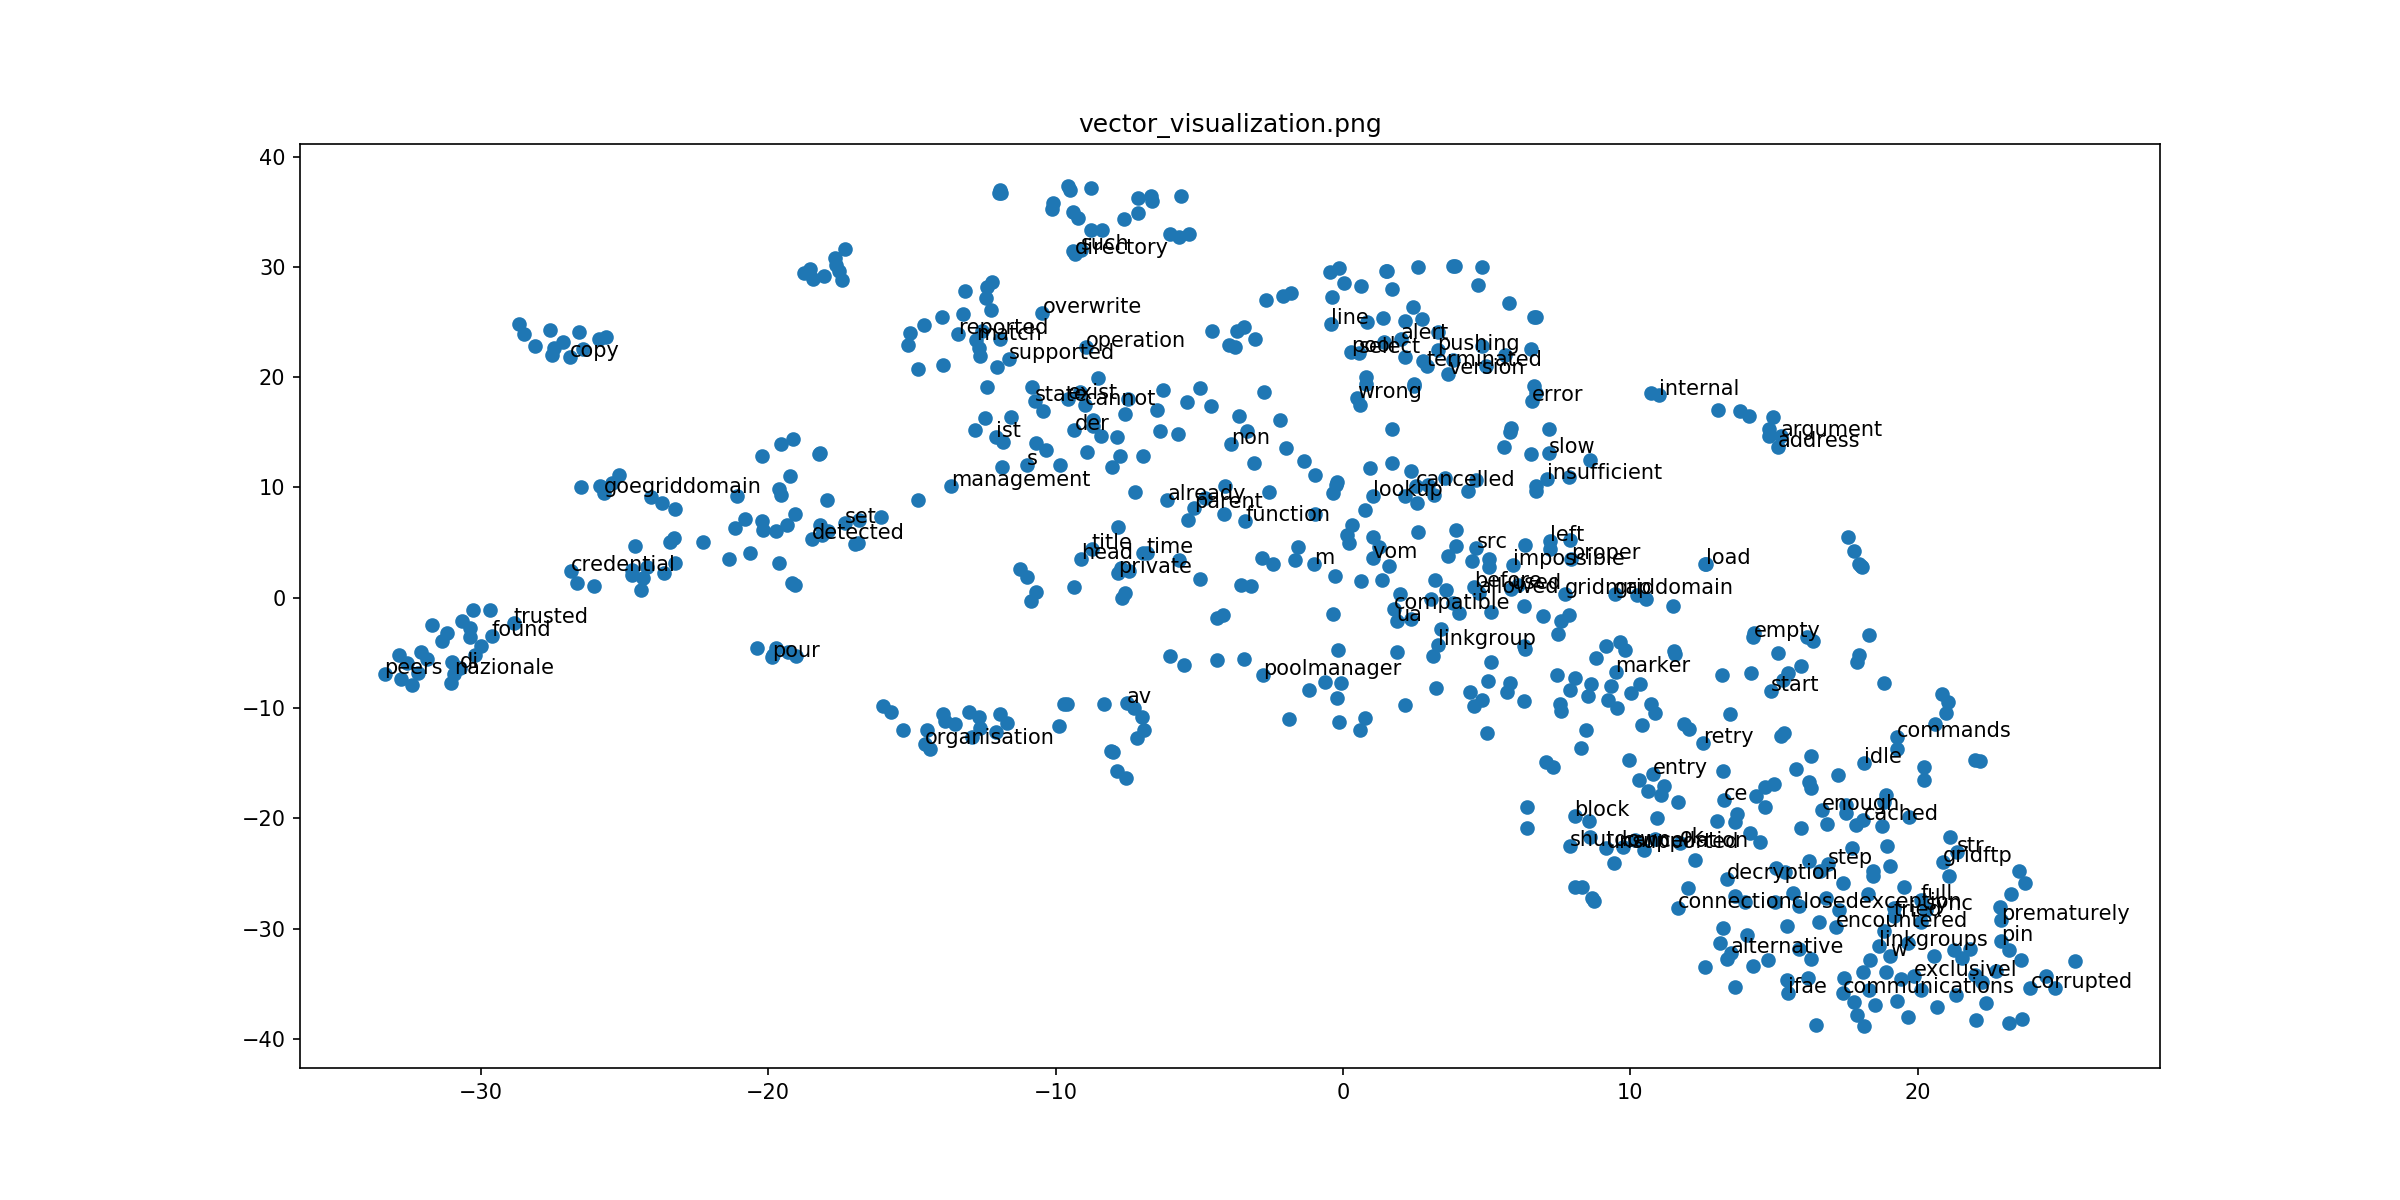

In [46]:
title='vector_visualization.png'
x_vals, y_vals, labels =nlp_utility.reduce_dimensions(model)
figsize=(16, 8)
nlp_utility.plot_with_matplotlib(x_vals, y_vals, labels,figsize,title=title)


Click on a point to visualize the annotation associated.
To move the box, click on it and drag.

<IPython.core.display.Javascript object>


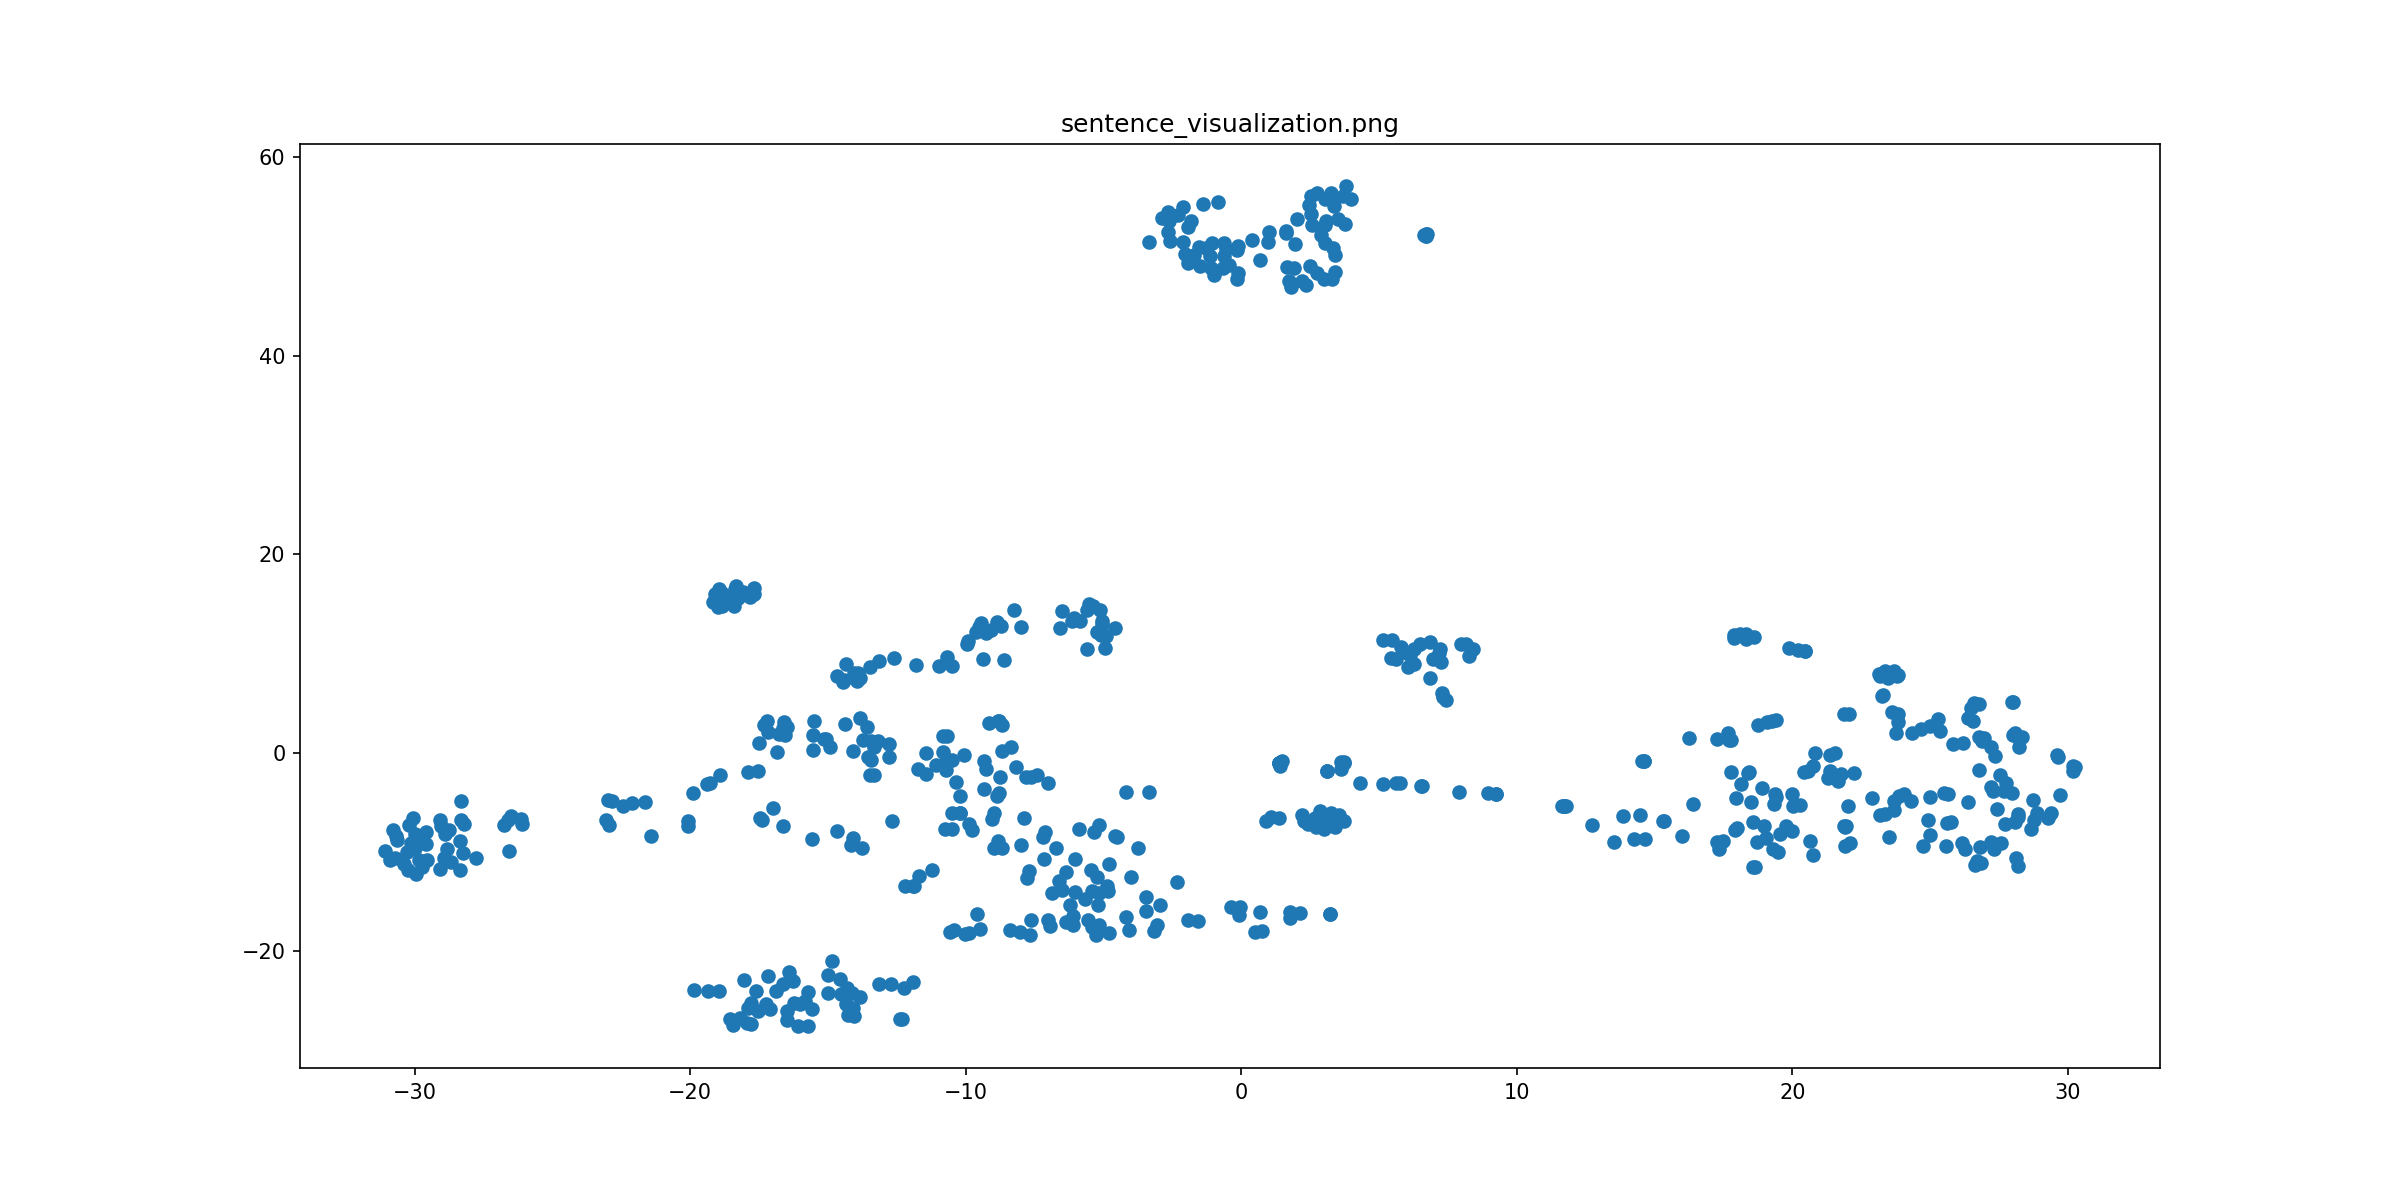

In [47]:
title='sentence_visualization.png'

df_cleaned['vectors_sent']=vectors_sent.tolist()
x_vals_sent, y_vals_sent, labels_sent=nlp_utility.reduce_sent_dimensions(df_cleaned)
figsize=(16,8)
nlp_utility.plot_with_matplotlib(x_vals_sent, y_vals_sent, labels_sent,figsize,npoints=0,save=True,title=title)

